# Mod 5 Project - Sandy's Notebook

## Imports and Data Ingestion

In [354]:
#import libraries

import mod_5_project_helper as hp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score


#set environment - REMEMBER TO COPY OVER mod_5_project_helper.py

hp.set_environment()
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

#initiliase variables

%run variables.py

#import data

df = pd.read_csv("data.csv")

## Data Cleanup

In [246]:
df.drop_duplicates(inplace = True) #drop 10,728 duplicate rows

In [247]:
df.drop(index = 100000, axis = 0, inplace = True) #delete last blank row in the data set

In [248]:
df.drop(df[df["Current Loan Amount"] == 99999999].index, inplace = True) #delete 11484 rows where the loan amount is 99999999

In [249]:
df.dropna(subset = ['Credit Score'], inplace = True) #delete 19154 rows where Credit Score is missing

In [250]:
df.dropna(subset = ['Years in current job'], inplace = True) #delete 2564 rows where Years in current job is missing 

In [251]:
df["Years in current job"].replace(to_replace = "year.*", value = "",inplace = True, regex = True) #remove 'years' or 'year' from string

In [252]:
df.drop(df[df["Home Ownership"] == "HaveMortgage"].index, inplace = True) #delete 120 rows with "HaveMortgage" as meaning isn't clear

In [253]:
df.dropna(subset = ['Months since last delinquent'], inplace = True) #delete 30,000 rows where data is missing 

In [254]:
df.drop(columns = "Maximum Open Credit", inplace = True) #delete Maximum Open Credit columns as some of these numbers are huge e.g. 798255370.0

In [255]:
df = hp.drop_column_keyword_search(df, ["Loan ID", "Customer ID"]) #delete features 'Loan ID' and 'Customer ID' as they don't add anything

In [256]:
df = df.fillna(df.median()) #fill remaining values with 

In [257]:
#rename and consolidate categorical variables for purpose

df["Purpose"].replace({
              "Business Loan": "business_loan",
              "Medical Bills": "medical bills",
              "Educational Expenses": "educational_expenses",
              "Buy House": "buy_house",
              "Buy a Car": "buy_a_car",
              "Debt Consolidation": "debt_consolidation",
              "Home Improvements": "home_improvements",
              "Take a Trip": "take_a_trip",
              "vacation": "take_a_trip",
              "Major Purchase": "other",
              "Other": "other", 
              "renewable_energy": "home_improvements",
              "small_business": "business_loan",
              "moving": "home_improvements",
              "major_purchase": "major_purchase",
              "wedding": "wedding"
              }, inplace=True)

In [258]:
#rename categorical variables for Home Ownership

df["Home Ownership"].replace({
              "Home Mortgage": "mortgage",
              "Rent": "rent",
              "Own Home": "own_home",
              }, inplace=True)

In [259]:
#rename categorical variables for Term

df["Term"].replace({
              "Long Term": "long_term",
              "Short Term": "short_term",
              }, inplace=True)

In [260]:
#rename categorical variables for Loan Status

df["Loan Status"].replace({
              "Fully Paid": "fully_paid",
              "Charged Off": "default",
              }, inplace=True)

In [261]:
#rename columns to make the dataset easier to work with using . notation

df.columns = ['loan_status',
              'loan_amount',
              'term',
              'credit_score',
              'annual_income',
              'years_in_current_job',
              'home_ownership',
              'loan_purpose',
              'monthly_debt',
              'years_of_credit_history',
              'months_since_last_delinquent',
              'number_of_open_accounts',
              'number_of_credit_problems',
              'current_credit_balance',
              'bankruptcies',
              'tax_liens']

In [270]:
df.reset_index(inplace = True); #reset index
df.drop(columns = "index", inplace = True) #remove extra index columns as not needed
df['loan_status_binary_value'] = np.where(df["loan_status"] == "fully_paid",1,0) #add a binary columns for loan_status with 1 = "fully_paid" and 0 = "default"

## Cleaned Dataset Information

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   26401 non-null  object 
 1   loan_amount                   26401 non-null  float64
 2   term                          26401 non-null  object 
 3   credit_score                  26401 non-null  float64
 4   annual_income                 26401 non-null  float64
 5   years_in_current_job          26401 non-null  object 
 6   home_ownership                26401 non-null  object 
 7   loan_purpose                  26401 non-null  object 
 8   monthly_debt                  26401 non-null  float64
 9   years_of_credit_history       26401 non-null  float64
 10  months_since_last_delinquent  26401 non-null  float64
 11  number_of_open_accounts       26401 non-null  float64
 12  number_of_credit_problems     26401 non-null  float64
 13  c

In [265]:
df.shape

(26401, 16)

In [268]:
df.head()

,loan_status,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens,loan_status_binary_value
0,fully_paid,217646.0,short_term,730.0,1184194.0,< 1,mortgage,debt_consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,1.0,0.0,1
1,fully_paid,548746.0,short_term,678.0,2559110.0,2,rent,debt_consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,0.0,0.0,1
2,fully_paid,234124.0,short_term,727.0,693234.0,10+,rent,debt_consolidation,14211.24,24.7,46.0,10.0,1.0,28291.0,1.0,0.0,1
3,fully_paid,666204.0,long_term,723.0,1821967.0,10+,mortgage,debt_consolidation,17612.24,22.0,34.0,15.0,0.0,813694.0,0.0,0.0,1
4,default,317108.0,long_term,687.0,1133274.0,8,rent,debt_consolidation,9632.81,17.4,53.0,4.0,0.0,60287.0,0.0,0.0,0


## Train, test split, sampling and K-folds

In [273]:
#define X and y columns

X = df.drop(columns = ["loan_status", "loan_status_binary_value"])
y = df.loan_status_binary_value

In [276]:
#define train, validation and test data 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [280]:
#make a dataframe of categorical variables - training data

X_train_categorical = pd.concat([X_train.term, 
                                 X_train.years_in_current_job, 
                                 X_train.home_ownership, 
                                 X_train.loan_purpose], 
                                 axis = 1) 

In [281]:
#make a dataframe of continous variables - training data

X_train_continuous = pd.concat([X_train.loan_amount, 
                                X_train.credit_score, 
                                X_train.annual_income, 
                                X_train.monthly_debt, 
                                X_train.years_of_credit_history,
                                X_train.months_since_last_delinquent,
                                X_train.number_of_open_accounts,
                                X_train.current_credit_balance,
                                X_train.bankruptcies,
                                X_train.tax_liens], 
                                axis = 1)

In [282]:
#one hot encode categorical variables - training data
#for everything but decision trees we should do drop_first = True
X_train_one_hot_encoded = pd.get_dummies(X_train_categorical)

In [283]:
#stitch the one hot encoded dataframe back together - training data

X_train_all_numbers = pd.concat([X_train_continuous, X_train_one_hot_encoded], axis = 1)

In [285]:
#make a dataframe of categorical variables - validation data

X_val_categorical = pd.concat([X_val.term, 
                               X_val.years_in_current_job, 
                               X_val.home_ownership, 
                               X_val.loan_purpose], 
                               axis = 1) 

In [286]:
#make a dataframe of continous variables - validation data

X_val_continuous = pd.concat([X_val.loan_amount, 
                              X_val.credit_score, 
                              X_val.annual_income, 
                              X_val.monthly_debt, 
                              X_val.years_of_credit_history,
                              X_val.months_since_last_delinquent,
                              X_val.number_of_open_accounts,
                              X_val.current_credit_balance,
                              X_val.bankruptcies,
                              X_val.tax_liens], 
                              axis = 1)

In [321]:
#one hot encode categorical variables - validation data
#for everything but decision trees we should do drop_first = True
X_val_one_hot_encoded = pd.get_dummies(X_val_categorical)

In [322]:
#stitch the one hot encoded dataframe back together - validation data

X_val_all_numbers = pd.concat([X_val_continuous, X_val_one_hot_encoded], axis = 1)

In [323]:
#use SMOTE to resample training data

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all_numbers, y_train) 

In [324]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42) #initialise cross validation object

In [325]:
#export data for CSVs for ease

X_train_resampled.to_csv("X_train.csv")
X_val_all_numbers.to_csv("X_val.csv")
y_train_resampled.to_csv("y_train.csv")
y_val.to_csv("y_val.csv")

## Decision Trees

In [371]:
#instantiate tree classifier object

tree_clf = DecisionTreeClassifier(max_depth = 15, min_samples_leaf = 20, random_state = 42)

In [372]:
#fit model using cross validation. Need to check this to make sure the approach is accurate and use ROC curve
#with hyperparamter tuning

baseline_tree_model = cross_validate(tree_clf, 
                                X_train_resampled, 
                                y_train_resampled, 
                                scoring='roc_auc',
                                cv=crossvalidation, 
                                return_train_score = True,
                                n_jobs = -1)

baseline_tree_model


{'fit_time': array([0.42533708, 0.42643094, 0.45026708, 0.45984316, 0.36497498,
        0.36605525, 0.39186597, 0.38603878, 0.23203802, 0.23015404]),
 'score_time': array([0.00786114, 0.00906706, 0.00831795, 0.01695395, 0.00704813,
        0.006598  , 0.00865793, 0.00874805, 0.00493813, 0.00488091]),
 'test_score': array([0.84707558, 0.84935008, 0.8659114 , 0.85557295, 0.82994254,
        0.84824   , 0.86049997, 0.86538984, 0.86322291, 0.85070755]),
 'train_score': array([0.92387469, 0.92504617, 0.92325283, 0.9236792 , 0.92490388,
        0.9237908 , 0.92244326, 0.92601064, 0.92489505, 0.92532577])}

In [373]:
tree_clf.fit(X_train_resampled,y_train_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [374]:
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [375]:
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [376]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [377]:
len(y_val)

4224

train: 0.93 test: 0.68


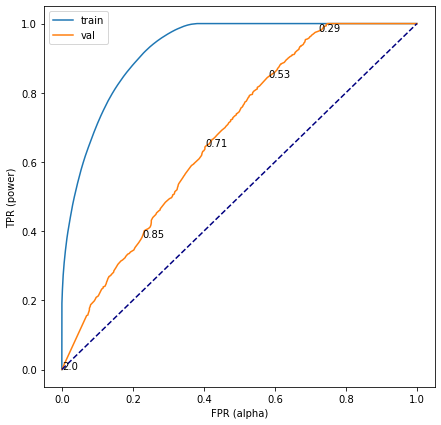

In [378]:
scores(tree_clf,X_train_resampled,X_val_all_numbers,y_train_resampled,y_val)
roc_plot(tree_clf,X_train_resampled,y_train_resampled,X_val_all_numbers,y_val)



In [107]:
tree_model_y_train_pred = cross_val_predict(tree_clf, 
                                            X_train_updated,
                                            y_train,
                                            cv = crossvalidation)

In [113]:
confusion_matrix(y_train, tree_model_y_train_pred)

array([[2690, 3314],
       [ 931, 5031]])

In [ ]:
#confusion matrix layout:

#  TN  FP
#  FN  TP

# So to summarise:

#1) - TN - We correctly identified 2690 as being paid loans when they were 
#2) - TP - We correctly identfied 5031 loans as being default when they are
#3) - FP - We incorrectly indentified 3314 loans as being paid when they aren't
#4) - FN - We incorrectly indentifed 931 loans as being default when they aren't

In [150]:
tree_clf.fit(X_train_updated,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [153]:
y_train_score = tree_clf.predict_proba(X_train_updated)

In [156]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score[:,1])

ValueError: y_true takes value in {'default', 'fully_paid'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [55]:
#export tree to a dot file so it can be converted to an image using the CLI:
# dot -Tpng tree.dot -o tree.png

export_graphviz(tree_clf, 
                out_file = ("tree.dot"), 
                feature_names = X_train_updated.columns, 
                class_names = y_train.values, 
                rounded = True, 
                filled = True)

In [36]:
rnd_clf = RandomForestClassifier(n_estimators = 500,
                               max_leaf_nodes = 16,
                               n_jobs = -1,
                               random_state = 42)

In [123]:
baseline_forest_model = cross_validate(rnd_clf,
                                       X_train_updated,
                                       y_train,
                                       cv = crossvalidation,
                                       return_train_score = True)
baseline_forest_model

{'fit_time': array([2.62067509, 2.37249088, 2.73847508, 2.43558884, 2.38792706,
        2.4939611 , 2.34673882, 2.5359509 , 2.35448909, 2.36896491]),
 'score_time': array([0.21141291, 0.21368885, 0.21379304, 0.2152729 , 0.212672  ,
        0.21272492, 0.21909308, 0.21522403, 0.21227288, 0.21321702]),
 'test_score': array([0.65162907, 0.6566416 , 0.64076859, 0.65079365, 0.63659148,
        0.66499582, 0.65133779, 0.66973244, 0.66471572, 0.65217391]),
 'train_score': array([0.66700715, 0.66366422, 0.66635714, 0.6659857 , 0.66607856,
        0.6634785 , 0.66666667, 0.6632312 , 0.6643454 , 0.66573816])}

In [37]:
grid_params = [{'n_estimators' : [500, 600, 700, 800, 900, 1000],
                'max_features' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}]

In [41]:
grid_search_random_forest = GridSearchCV(rnd_clf, grid_params, cv = crossvalidation, return_train_score = True)

In [53]:
grid_search_random_forest.fit(X_train_updated, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=16,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=-1,
                                              oob_score=F

In [54]:
grid_search_random_forest.best_params_

{'max_features': 18, 'n_estimators': 1000}

In [55]:
grid_search_random_forest.cv_results_

{'mean_fit_time': array([ 2.21225586,  2.0878819 ,  2.44974189,  2.80376911,  2.9700597 ,
         3.50117252,  2.17909062,  2.57878382,  2.89939718,  3.44554627,
         3.74630961,  4.11255682,  2.69546959,  2.79165008,  3.22223573,
         3.79034204,  4.00761888,  4.75887332,  2.75479052,  3.54295464,
         3.86126466,  4.28136194,  4.87407742,  5.43022313,  3.13828785,
         3.70023835,  4.30339413,  4.95367599,  5.48059928,  6.37810421,
         4.7456418 ,  5.84136319,  5.04358559,  5.59796865,  6.29653046,
         6.86260378,  3.94972184,  4.61423905,  5.48236017,  6.51252835,
         6.83500726,  7.85078938,  4.3424279 ,  5.1191236 ,  5.92152264,
         6.7282346 ,  7.52062311,  8.68328595,  4.91735568,  5.56901319,
         7.11079309,  7.33125362,  8.31801004,  9.32897203,  5.09386921,
         6.41328359,  7.10741868,  8.23026955,  9.16182854, 10.09367759]),
 'std_fit_time': array([0.99758259, 0.09517019, 0.1545531 , 0.16646824, 0.18970981,
        0.40384292, 0

In [59]:
best_forest_model_clf = RandomForestClassifier(n_estimators = 1000,
                                               max_leaf_nodes = 18,
                                               n_jobs = -1,
                                               random_state = 42)

In [60]:
random_forest_best_results = cross_validate(best_forest_model_clf, 
                                            X_train_updated, 
                                            y_train, 
                                            cv=crossvalidation, 
                                            return_train_score = True)

In [62]:
random_forest_best_results

{'fit_time': array([6.80627894, 9.42683792, 5.25640798, 5.53262615, 5.49912071,
        5.29805017, 5.42514992, 5.17917514, 4.87725997, 5.007797  ]),
 'score_time': array([0.52748418, 0.516747  , 0.52846909, 0.52315497, 0.42249823,
        0.41807485, 0.4221561 , 0.41293383, 0.41814995, 0.52153683]),
 'test_score': array([0.65079365, 0.66248956, 0.64578112, 0.65329992, 0.64160401,
        0.6641604 , 0.65133779, 0.67056856, 0.66638796, 0.65301003]),
 'train_score': array([0.67035008, 0.66654285, 0.66877147, 0.66914291, 0.66858576,
        0.66728573, 0.66898793, 0.66824513, 0.66852368, 0.66805942])}

In [ ]:
#do we need to maximize FPR or TPR for our business case?